In [6]:
import os
import uproot as ur
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [10]:
data_features = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features.csv')
data_labels = np.loadtxt('/home/dmisra/eic/zdc_data/dnn_labels.csv', delimiter=',')

In [11]:
data_features_10GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_10GeV.csv')
data_features_20GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_20GeV.csv')
data_features_50GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_50GeV.csv')
data_features_100GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_100GeV.csv')
data_features_150GeV = pd.read_csv('/home/dmisra/eic/zdc_data/dnn_features_150GeV.csv')

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.manual_seed(42)

In [14]:
features = torch.from_numpy(data_features.values).float()

labels = torch.from_numpy(data_labels).T.float().unsqueeze(dim=1)

/tmp/ipykernel_269124/290568624.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642922335/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  labels = torch.from_numpy(data_labels).T.float().unsqueeze(dim=1)


In [15]:
features.size(), labels.size()

(torch.Size([50000, 67]), torch.Size([50000, 1]))

In [16]:
features_10GeV = torch.from_numpy(data_features_10GeV.values).float()
features_20GeV = torch.from_numpy(data_features_20GeV.values).float()
features_50GeV = torch.from_numpy(data_features_50GeV.values).float()
features_100GeV = torch.from_numpy(data_features_100GeV.values).float()
features_150GeV = torch.from_numpy(data_features_150GeV.values).float()

In [17]:
#Split train/test data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [18]:
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [56]:
class Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self,x):
        out = self.layer_stack(x)
        return out

In [85]:
model_1 = Model(input_shape=67, hidden_units=1024, output_shape=1)

In [86]:
def custom_loss(output, target):
    loss = torch.mean(((output - target)*target**(-1))**2)
    return loss

In [87]:
learning_rate = 0.0005
loss_fn = custom_loss
optimizer = torch.optim.Adam(model_1.parameters(),lr=learning_rate)

In [88]:
#Set number of epochs
epochs = 2000

#Create lists to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    model_1.train()

    for inputs, labels in dataloader:

        ###Training
        y_pred = model_1(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ###Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(x_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")

Epoch: 0 | MSE Train Loss: 0.3078668415546417 | MSE Test Loss: 0.288841187953949
Epoch: 10 | MSE Train Loss: 0.026690054684877396 | MSE Test Loss: 0.022766178473830223
Epoch: 20 | MSE Train Loss: 0.02754664421081543 | MSE Test Loss: 0.022009078413248062
Epoch: 30 | MSE Train Loss: 0.02719622664153576 | MSE Test Loss: 0.021133972331881523
Epoch: 40 | MSE Train Loss: 0.019642584025859833 | MSE Test Loss: 0.021010471507906914
Epoch: 50 | MSE Train Loss: 0.010638855397701263 | MSE Test Loss: 0.020257186144590378
Epoch: 60 | MSE Train Loss: 0.0278570968657732 | MSE Test Loss: 0.02001749910414219
Epoch: 70 | MSE Train Loss: 0.011791246943175793 | MSE Test Loss: 0.019873565062880516
Epoch: 80 | MSE Train Loss: 0.012351329438388348 | MSE Test Loss: 0.01956103928387165
Epoch: 90 | MSE Train Loss: 0.014736486598849297 | MSE Test Loss: 0.019548173993825912
Epoch: 100 | MSE Train Loss: 0.01653243973851204 | MSE Test Loss: 0.019178863614797592
Epoch: 110 | MSE Train Loss: 0.01688406988978386 | MSE 

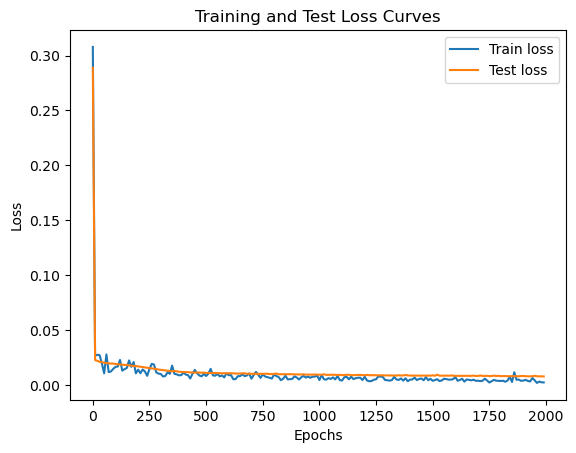

In [89]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

Predictions

In [90]:
from scipy.stats import norm
from scipy.optimize import curve_fit

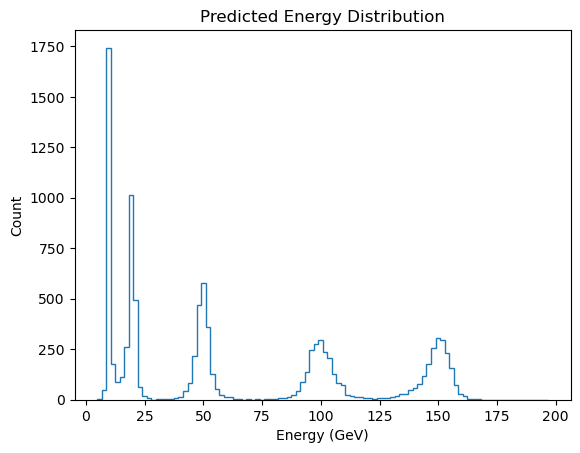

In [91]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_1(x_test)

plt.hist(y_preds[:,0].numpy(),100,histtype='step')
plt.xlabel('Energy (GeV)')
plt.ylabel('Count')
plt.title('Predicted Energy Distribution')
plt.savefig("dnn_distibution.pdf")

In [92]:
def tensorIntersect(t1, t2):
    a = set((tuple(i) for i in t1.numpy()))
    b = set((tuple(i) for i in t2.numpy()))
    c = a.intersection(b)
    tensorform = torch.from_numpy(np.array(list(c)))

    return tensorform

In [93]:
test_150GeV = tensorIntersect(features_150GeV, x_test)
test_100GeV = tensorIntersect(features_100GeV, x_test)
test_50GeV = tensorIntersect(features_50GeV, x_test)
test_20GeV = tensorIntersect(features_20GeV, x_test)
test_10GeV = tensorIntersect(features_10GeV, x_test)

In [94]:
#Set the model in evaluation mode
model_1.eval()

#Setup the inference mode context manager
with torch.inference_mode():
  y_preds_150GeV = model_1(test_150GeV)
  y_preds_100GeV = model_1(test_100GeV)
  y_preds_50GeV = model_1(test_50GeV)
  y_preds_20GeV = model_1(test_20GeV)
  y_preds_10GeV = model_1(test_10GeV)

In [95]:
peak_preds = norm.fit(y_preds_10GeV)[0], norm.fit(y_preds_20GeV)[0], norm.fit(y_preds_50GeV)[0], norm.fit(y_preds_100GeV)[0], norm.fit(y_preds_150GeV)[0]
true_peaks = [10,20,50,100,150]
peak_preds

(10.20062, 19.410103, 49.601517, 100.44984, 148.88086)

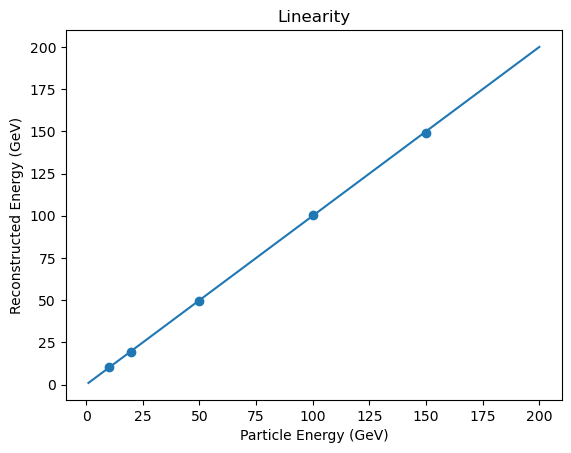

In [96]:
plt.scatter(true_peaks,peak_preds)
plt.xlabel('Particle Energy (GeV)')
plt.ylabel('Reconstructed Energy (GeV)')
plt.plot(np.arange(1,201),np.arange(1,201))
plt.title('Linearity')
plt.savefig("dnn_linearity.pdf")

In [97]:
#Get energy resolution from distribution of predictions
def res(preds,energy):
    return norm.fit(preds)[1]/energy

energy_list = [150,100,50,20,10]
resolutions = res(y_preds_150GeV,150), res(y_preds_100GeV,100), res(y_preds_50GeV,50), res(y_preds_20GeV,20), res(y_preds_10GeV,10)

In [98]:
#Curve fit for energy resolution as a function of energy
def f(E,a,b):
    return np.sqrt((a/np.sqrt(E))**2 + b**2)

popt, pcov = curve_fit(f, energy_list, resolutions)

In [99]:
popt, pcov

(array([0.33427872, 0.05676074]),
 array([[ 0.00339124, -0.00047702],
        [-0.00047702,  0.00015049]]))

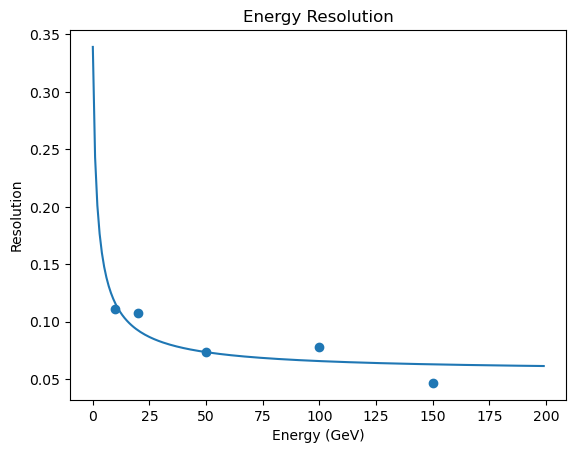

In [100]:
plt.plot(range(200),f(range(1,201),popt[0], popt[1]))
plt.scatter(energy_list,resolutions)
plt.xlabel('Energy (GeV)')
plt.ylabel('Resolution')
plt.title('Energy Resolution')
plt.savefig("dnn_res.pdf")

In [101]:
torch.save(obj=model_1.state_dict(), f="/home/dmisra/eic/model_1")

In [18]:
model_1.load_state_dict(torch.load('/home/dmisra/eic/model_1'))

<All keys matched successfully>